### Step 1: Data Visualization

**1. Import Libraries: Load essential libraries**

In [1]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime
import folium
from folium.plugins import HeatMap

**2. Load Data: Import aircrash dataset.**

In [2]:
# Load Data
data_path = "updated_Airplane_Crashes.csv"
data = pd.read_csv(data_path)

# Inspect Data
print(data.head())
print(data.info())

        Date   Time                            Location  \
0  9/17/1908  17:18            Fort Myer, Virginia, USA   
1   9/7/1909  00:00             Juvisy-sur-Orge, France   
2  7/12/1912   6:30      Atlantic City, New Jersey, USA   
3   8/6/1913  00:00  Victoria, British Columbia, Canada   
4   9/9/1913  18:30                  Over the North Sea   

                 Operator Flight #          Route                 AC Type  \
0    Military - U.S. Army      NaN  Demonstration        Wright Flyer III   
1                     NaN      NaN       Air show          Wright Byplane   
2    Military - U.S. Navy      NaN    Test flight               Dirigible   
3                 Private      NaN            NaN        Curtiss seaplane   
4  Military - German Navy      NaN            NaN  Zeppelin L-1 (airship)   

  Registration cn/ln  Aboard  Aboard Passangers  Aboard Crew  Fatalities  \
0          NaN     1     2.0                1.0          1.0         1.0   
1          SC1   NaN     1.0  

**3. Trend Analysis Over Time:** Create a time-series plot to show the number of crashes per year.

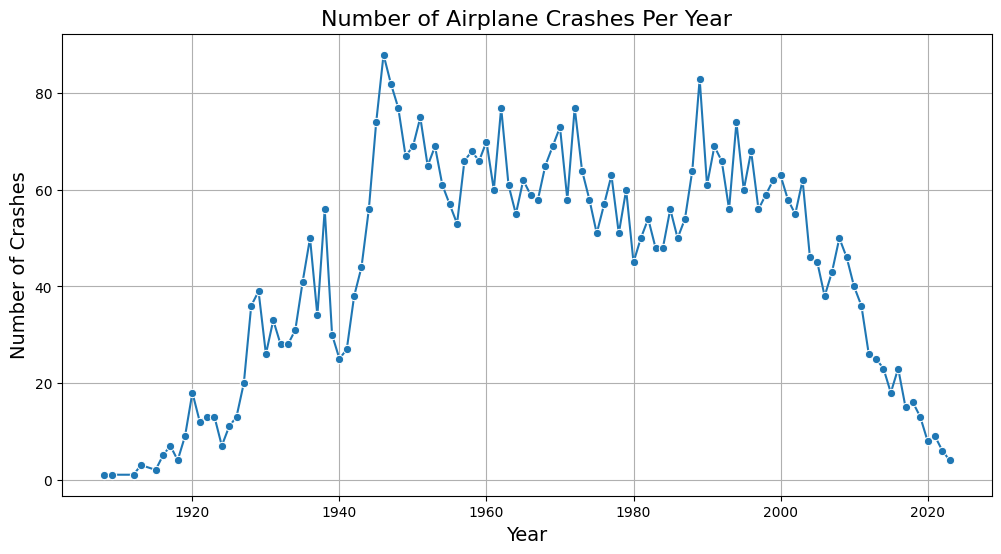

In [3]:
# Trend Analysis Over Time
# Convert the Date column to datetime format if it exists
if 'Date' in data.columns:
    data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
    data['Year'] = data['Date'].dt.year
    
    # Count crashes per year
    yearly_crashes = data.groupby('Year').size().reset_index(name='Crashes')

    # Plot time-series of crashes
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=yearly_crashes, x='Year', y='Crashes', marker='o')
    plt.title('Number of Airplane Crashes Per Year', fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Number of Crashes', fontsize=14)
    plt.grid(True)
    plt.show()

**4. Crashes by Flight Category:** Create a bar plot or pie chart to show the distribution of crashes by flight category.

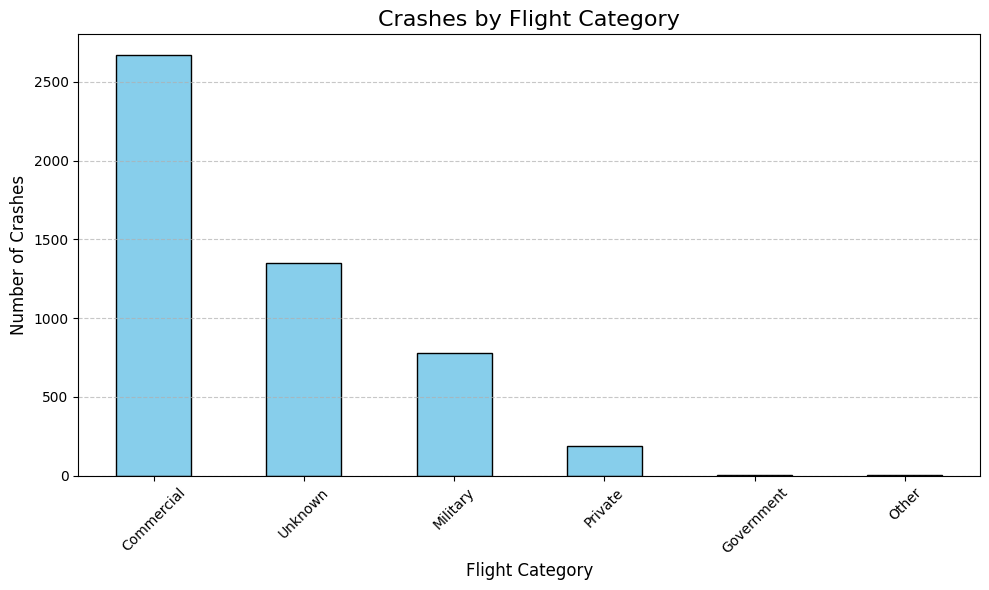

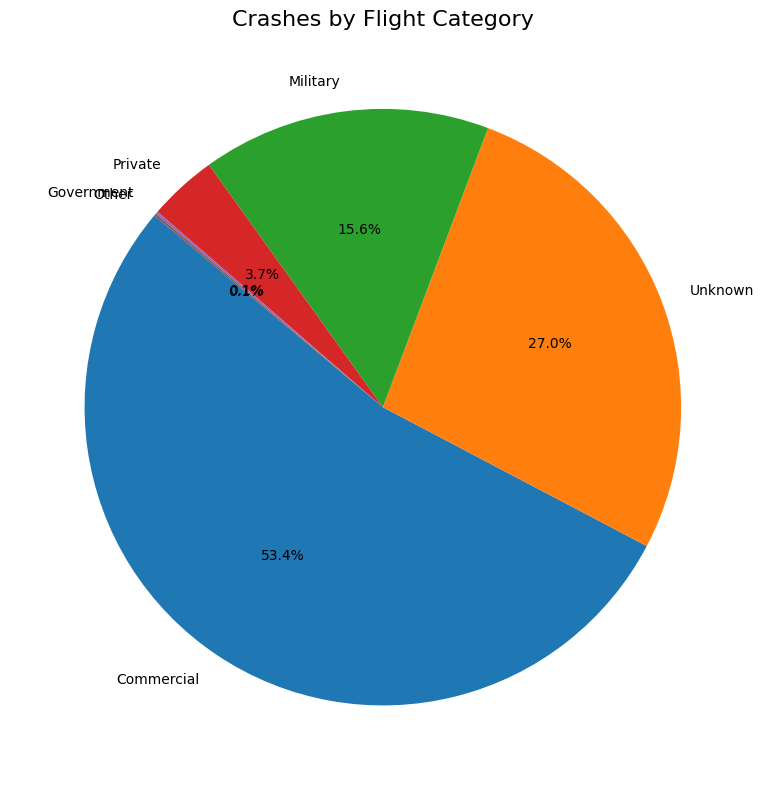

In [16]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from rapidfuzz import process as rf_process

# File paths
operators_file = 'unique_operators.txt'  # Replace with your file path
crashes_file = 'updated_Airplane_Crashes.csv'  # Replace with your file path

# Step 1: Define expanded categories
categories = {
    'Military': ['Military', 'Air Force', 'Navy', 'Army', 'Marine Corps', 'Defense'],
    'Private': ['Private', 'Charter', 'Taxi', 'Club', 'Skydiving'],
    'Commercial': ['Airlines', 'Airways', 'Aeroflot', 'Aeroplane', 'Air', 'Lines', 'Aircraft', 'Transport', 'Cargo', 'Express', 'Service'],
    'Government': ['Government', 'Police', 'Border', 'State'],
    'Other': ['Historical', 'Research', 'Union', 'Society', 'Mission', 'Educational'],
    'Unknown': []  # Catch-all for unmatched operators
}

# Function to classify operator based on keywords
def classify_operator(operator):
    for category, keywords in categories.items():
        if any(keyword.lower() in operator.lower() for keyword in keywords):
            return category
    return 'Unknown'

# Reading operators file
with open(operators_file, 'r') as file:
    operators = file.readlines()

# Processing operators
operators = [op.strip() for op in operators if op.strip()]  # Remove empty lines and strip whitespace
operator_categories = {op: classify_operator(op) for op in operators}

# List of normalized operators for fuzzy matching
normalized_operators_list = list(operator_categories.keys())

# Step 2: Load and process the crash file
crashes_df = pd.read_csv(crashes_file)

# Ensuring operator names in the crash file are strings
crashes_df['Operator'] = crashes_df['Operator'].fillna('').astype(str)

# Optimized function for classification with fuzzy matching
def classify_operator_optimized(operator, normalized_operators, threshold=80):
    """
    Optimized function to classify an operator using fuzzy matching from RapidFuzz.
    """
    # Exact match
    if operator in operator_categories:
        return operator_categories[operator]
    
    # Fuzzy match for "Unknown" only
    if operator.strip():
        match, score, _ = rf_process.extractOne(operator, normalized_operators, score_cutoff=threshold)
        if match:
            return operator_categories[match]
    
    return 'Unknown'

# Re-classify operators in the crash dataset using optimized fuzzy matching
crashes_df['Category'] = crashes_df['Operator'].apply(
    lambda x: classify_operator_optimized(x, normalized_operators_list) if x else 'Unknown'
)

# Step 3: Analyze and visualize crash data by category
crash_counts = crashes_df['Category'].value_counts()

# Plotting Bar Chart
plt.figure(figsize=(10, 6))
crash_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Crashes by Flight Category', fontsize=16)
plt.xlabel('Flight Category', fontsize=12)
plt.ylabel('Number of Crashes', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plotting Pie Chart
plt.figure(figsize=(8, 8))
crash_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=plt.cm.tab10.colors)
plt.title('Crashes by Flight Category', fontsize=16)
plt.ylabel('')  # Remove y-label for aesthetics
plt.tight_layout()
plt.show()

# Saving the results
crashes_df.to_csv('classified_crashes_expanded.csv', index=False)


**5. Hotspot Map:** Use geographic plotting libraries like Folium or Plotly to create a heatmap of crash locations.

In [19]:
# Importing necessary libraries
import pandas as pd
import folium
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim
import time

# File path for crash data
crashes_file = 'updated_Airplane_Crashes.csv'  # Replace with your file path

# Step 1: Load crash data
data = pd.read_csv(crashes_file)

# Step 2: Geocode the location column (City, Country) to get latitude and longitude
geolocator = Nominatim(user_agent="crash_hotspot_map")

# Function to get latitude and longitude from location
def geocode_location(location):
    try:
        # Split the location into city and country
        location_obj = geolocator.geocode(location)
        if location_obj:
            return (location_obj.latitude, location_obj.longitude)
        else:
            return None
    except Exception as e:
        print(f"Error geocoding {location}: {e}")
        return None

# Apply the geocoding function to the "Location" column
data[['Latitude', 'Longitude']] = data['Location'].apply(lambda x: pd.Series(geocode_location(x)))

# Step 3: Filter out rows with missing or invalid coordinates
geo_data = data.dropna(subset=['Latitude', 'Longitude'])

# Step 4: Initialize a folium map
crash_map = folium.Map(location=[0, 0], zoom_start=2)  # Global map

# Step 5: Create heatmap data (latitude, longitude)
heat_data = geo_data[['Latitude', 'Longitude']].values.tolist()

# Step 6: Add heatmap to the map
HeatMap(heat_data).add_to(crash_map)

# Step 7: Save and display map
crash_map.save('crash_heatmap.html')  # Save as an HTML file
crash_map  # Display map in Jupyter Notebook (if running there)


Error geocoding Goshen, Indiana, USA: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Goshen%2C+Indiana%2C+USA&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
Error geocoding Az-Zubair, Iran: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Az-Zubair%2C+Iran&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
Error geocoding New York, New York, USA: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=New+York%2C+New+York%2C+USA&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
Error geocoding Ocean, 800 miles east